In [1]:
import torch
import torch.nn as nn

#Model

In [2]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()

    self.net = nn.Sequential(
        nn.Linear(3,64),
        nn.Tanh(),
        nn.Linear(64,64),
        nn.Tanh(),
        nn.Linear(64,2)
    )

  def forward(self,x):
    return self.net(x)


#Training

In [3]:
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

In [5]:
#-------------
# Load data
#-------------

data = np.load("pendulum_dataset.npz")
split = np.load("splits.npz")

X = np.hstack([data["X"], data["U"]])
Y = data["X_next"]

X_train = X[split["train_idx"]]
Y_train = Y[split["train_idx"]]

X_test = X[split["test_idx"]]
Y_test = Y[split["test_idx"]]

#-------------------
# Convert to tensor
#-------------------

X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

#---------
#  Model
#---------

model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

#----------------
# Training loop
#----------------

n_epochs = 50

for epoch in range(n_epochs):
  model.train()
  train_loss = 0.0

  for X_batch, Y_batch in train_loader:
    Y_pred = model(X_batch)
    loss = loss_fn(Y_pred, Y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_loader)

  model.eval()

  with torch.no_grad(): # Compute loss on test dataset without grad
    test_loss = 0.0
    for X_batch, Y_batch in test_loader:
      Y_pred = model(X_batch)
      loss = loss_fn(Y_pred, Y_batch)

      test_loss += loss.item()

    test_loss /= len(test_loader)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

#-------------
# Save model
#-------------

torch.save(model.state_dict(), "mlp.pth")

Epoch 1/50, Train Loss: 0.8963, Test Loss: 0.4873
Epoch 2/50, Train Loss: 0.0724, Test Loss: 0.1177
Epoch 3/50, Train Loss: 0.0167, Test Loss: 0.0419
Epoch 4/50, Train Loss: 0.0057, Test Loss: 0.0192
Epoch 5/50, Train Loss: 0.0025, Test Loss: 0.0107
Epoch 6/50, Train Loss: 0.0014, Test Loss: 0.0074
Epoch 7/50, Train Loss: 0.0009, Test Loss: 0.0057
Epoch 8/50, Train Loss: 0.0006, Test Loss: 0.0047
Epoch 9/50, Train Loss: 0.0005, Test Loss: 0.0042
Epoch 10/50, Train Loss: 0.0004, Test Loss: 0.0038
Epoch 11/50, Train Loss: 0.0003, Test Loss: 0.0034
Epoch 12/50, Train Loss: 0.0002, Test Loss: 0.0032
Epoch 13/50, Train Loss: 0.0002, Test Loss: 0.0031
Epoch 14/50, Train Loss: 0.0002, Test Loss: 0.0029
Epoch 15/50, Train Loss: 0.0002, Test Loss: 0.0027
Epoch 16/50, Train Loss: 0.0001, Test Loss: 0.0025
Epoch 17/50, Train Loss: 0.0001, Test Loss: 0.0024
Epoch 18/50, Train Loss: 0.0001, Test Loss: 0.0024
Epoch 19/50, Train Loss: 0.0001, Test Loss: 0.0023
Epoch 20/50, Train Loss: 0.0001, Test Lo

# Analysis

In [10]:
import matplotlib.pyplot as plt
import copy

Needed functions

In [15]:
def pendulum_dynamics(x, u, params):  # Compute the function f(x,t) such that theta'' = f(x,t)
  theta, omega = x
  m, l, g = params["m"], params["l"], params["g"]
  u = float(u)

  d_theta = omega
  d_omega = (g/l) * np.sin(theta) + u/(m * l**2)

  return np.array([d_theta, d_omega])

def rk4_step(f, x, u, dt, params):  # Compute the position after a short time dt based on the pervious position using rk4 method
  k1 = f(x, u, params)
  k2 = f(x + 0.5 * dt * k1, u, params)
  k3 = f(x + 0.5 * dt * k2, u, params)
  k4 = f(x + dt * k3, u, params)

  return x + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

def trajectory_simulation(x0, u_control, dt, T, params):
  N = int(T/dt)
  x = np.zeros((N+1, 2))
  x[0] = x0
  for t in range(N):
    u = u_control(t * dt, x[t])
    x[t+1] = rk4_step(pendulum_dynamics, x[t], u, dt, params)
  return x

def zero_control(t,x):
  return 0

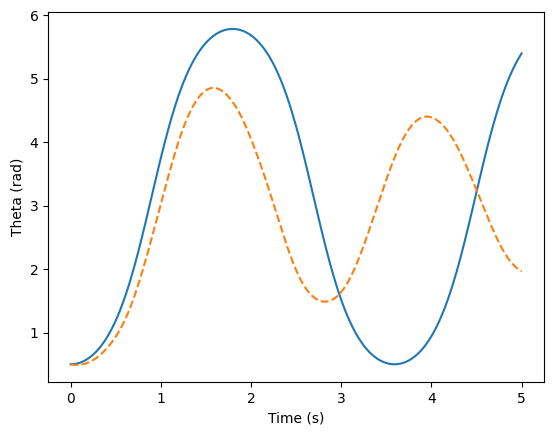

In [24]:
#--------------
# Parameters
#--------------
dt = data["dt"]
params = {"g":9.81, "l":1.0, "m":1.0}

#------------------
# Initialisation
#------------------
x0 = np.array([0.5,0.0])
T = 5.0

#------------------
# True trajectory
#------------------

true_traj = trajectory_simulation(x0, zero_control, dt, T, params)
u_traj = np.zeros(( int(T/dt), 1))

#-----------
# MLP traj
#-----------

x = x0.copy()
mlp_traj = [x]

for t in range(int(T/dt)):
  inp = torch.tensor(np.hstack([x,u_traj[t]]),
                     dtype=torch.float32
                     )
  with torch.no_grad():
    x = model(inp)
    mlp_traj.append(x)

mlp_traj = np.array(mlp_traj)

#-------
# Plot
#-------

t = np.arange(T/dt +1) * dt

plt.plot(t, true_traj[:,0], label = "True")
plt.plot(t, mlp_traj[:,0],"--", label = "MLP")
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.show()




#Energy validation

In [25]:
def mechanical_energy(x, params):    # Verification that Em is roughly constant
  m, l, g = params["m"], params["l"], params["g"]
  theta = x[:,0]
  omega = x[:,1]

  E = 0.5 * m * l**2 * omega**2 + m * g * l * np.cos(theta)
  return E

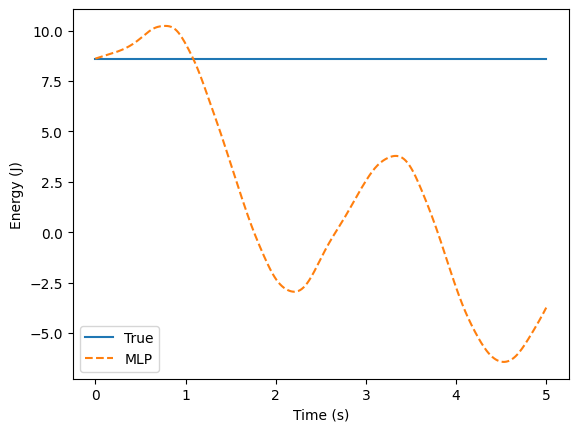

In [26]:
plt.plot(t, mechanical_energy(true_traj, params), label = "True")
plt.plot(t, mechanical_energy(mlp_traj, params),"--", label = "MLP")
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")
plt.legend()
plt.show()


#Phase portrait

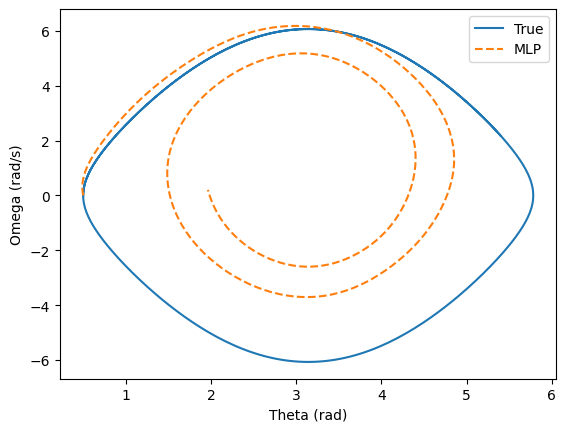

In [27]:
plt.plot(true_traj[:,0], true_traj[:,1], label = "True")
plt.plot(mlp_traj[:,0], mlp_traj[:,1],"--", label = "MLP")
plt.xlabel("Theta (rad)")
plt.ylabel("Omega (rad/s)")
plt.legend()
plt.show()